In [1]:
import re, math, urllib.request as req, numpy as np
from functools import reduce
import nltk.stem.snowball, bs4, collections
from scipy.spatial.distance import cosine

In [2]:
bookNames = ["Война и Мир 1", "Война и Мир 2", "Война и Мир 3", "Война и Мир 4", "Про войну", "Про Мышу"]
bookUrls = {
    "https://rvb.ru/tolstoy/01text/vol_4/0030_1.htm" : "windows-1251",
    "https://rvb.ru/tolstoy/01text/vol_5/0030_2.htm" : "windows-1251",
    "https://rvb.ru/tolstoy/01text/vol_6/0030_3.htm" : "windows-1251",
    "https://rvb.ru/tolstoy/01text/vol_7/0030_4.htm" : "windows-1251",
    "http://www.rastamantales.com/skazki/content/pro-voynu": "utf-8",
    "http://www.rastamantales.com/skazki/content/skazka-pro-myshu": "utf-8"}

# скачаем книжки
def getBook(url, enc):
    head = re.compile(r'<head.*?/head>')
    scripts = re.compile(r'<script.*?</script>')
    css = re.compile(r'<style.*?/style>')
    t = req.urlopen(url).read().decode(enc)
    t = head.sub('', t)
    t = scripts.sub('', t)
    t = css.sub('', t)
    # remove [...] {...} (...)
    t = re.sub('\[.*\]', '', t)
    t = re.sub('\(.*\)', '', t)
    t = re.sub('\{.*\}', '', t)
    return bs4.BeautifulSoup(t, "lxml").text

books = [getBook(*u) for u in bookUrls.items()]

In [3]:
# возьмём из каждого текста только слова
# длина которых больше 2 символов, и оставим от них только основы
def textToWords(text):
    stemmer = nltk.stem.snowball.RussianStemmer()
    return [stemmer.stem(word) for word in re.split('\W+', text) if len(word) > 2]
    
# тексты, разбитые на слова
bookWords = [textToWords(book) for book in books]
# все известные нам слова положим в множество, оно называется лексиконом.
lexiconSet = reduce(lambda s, all: all | s, map(set, bookWords), set())

print("Размер лексикона:", len(lexiconSet))

Размер лексикона: 13537


In [4]:
lexicon = list(lexiconSet)
# заведём вектор, в котором будет подсчитывать появления слов в текстах - term frequency
TF = [0] * len(lexicon)

def vectorize(bookW, lexicon, TF=None):
    stats = collections.Counter()
    for word in bookW:
        stats[word] += 1
    vector = [0] * len(lexicon)
    
    for j in range(len(lexicon)):
        vector[j] = stats[lexicon[j]]
        if TF is not None and vector[j]:
            TF[j] += 1
    return np.array(vector)

vectorBooks = []
for book in bookWords:
    vector = vectorize(book, lexicon, TF)
    vectorBooks.append(vector)

In [5]:
def norm(wordCount, tf, Nbooks):
    # первый множитель сглаживает влияние числа слов
    # второй множитель уменьшает влияние маловажных слов, которые есть во всех текстах
    return math.log(1 + wordCount, 2) * math.log(Nbooks / tf, 2)

def normVector(vector, TF):
    return list(map(lambda v: norm(*v, len(books)), zip(vector, TF)))

# https://ru.wikipedia.org/wiki/Терм-документная_матрица
TDindex = [np.array(normVector(vect, TF)) for vect in vectorBooks]

In [6]:
cosDistances = np.matrix([0.]*(len(books) ** 2)).reshape(len(books),len(books))

def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

for i in range(len(TDindex)):
    for j in range(len(TDindex)):
        cosDistances[i,j] = cosine(TDindex[i], TDindex[j])

In [7]:
print(cosDistances)

[[1.         0.36806658 0.35448181 0.32650929 0.00759717 0.00839773]
 [0.36806658 1.         0.35396584 0.31296691 0.01204977 0.01470012]
 [0.35448181 0.35396584 1.         0.34184257 0.00615333 0.00595274]
 [0.32650929 0.31296691 0.34184257 1.         0.00831747 0.00797465]
 [0.00759717 0.01204977 0.00615333 0.00831747 1.         0.21945127]
 [0.00839773 0.01470012 0.00595274 0.00797465 0.21945127 1.        ]]


In [8]:
def search(query):
    print("\nИщем:", query)
    prepared = textToWords(query)
    print("Запрос:", prepared)
    vect = vectorize(prepared, lexicon)
    print("Норма вектора запроса до TF-IDF:", np.linalg.norm(vect))
    vectN = normVector(vect, TF)
    print("Норма вектора запроса после:", np.linalg.norm(vectN))
    return sorted([(cosine(book[0], vectN), book[1]) for book in zip(TDindex, bookNames)], reverse=True)

print(*search("Пьер Безухов и Наташа Ростова на балу"), sep="\n")
print(*search("кони красноглазые"), sep="\n")


Ищем: Пьер Безухов и Наташа Ростова на балу
Запрос: ['пьер', 'безух', 'наташ', 'ростов', 'бал']
Норма вектора запроса до TF-IDF: 1.7320508075688772
Норма вектора запроса после: 4.477286386909343
(0.046264872359523534, 'Война и Мир 2')
(0.009547777769805116, 'Война и Мир 4')
(0.0, 'Про войну')
(0.0, 'Про Мышу')
(0.0, 'Война и Мир 3')
(0.0, 'Война и Мир 1')

Ищем: кони красноглазые
Запрос: ['кон', 'красноглаз']
Норма вектора запроса до TF-IDF: 1.4142135623730951
Норма вектора запроса после: 3.6556890267457303
(0.05352463283193378, 'Про Мышу')
(0.0, 'Про войну')
(0.0, 'Война и Мир 4')
(0.0, 'Война и Мир 3')
(0.0, 'Война и Мир 2')
(0.0, 'Война и Мир 1')


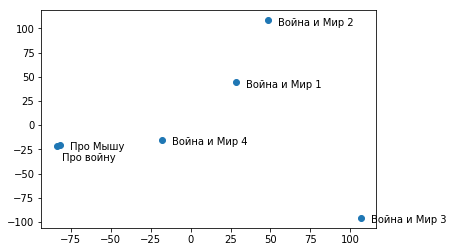

In [10]:
import matplotlib.pyplot as plt
# метод главных компонент - один из способов снижения размерности
# метод не конкретизирует, как выделять главные компоненты, но один из возможных способов - 
# сингулярное разложение матрицы (SVD), в нашем случае - терм-документной
from sklearn.decomposition import PCA

dimensions = 2
# Уменьшение размерности многомерных семантических векторов
# называют латентно-семантическим анализом
# https://ru.wikipedia.org/wiki/Латентно-семантический_анализ
model = PCA(n_components=dimensions).fit(TDindex) # в этом методе мы построили SVD
X_reduced = model.transform(TDindex)              # а здесь мы уже применили его к данным и получили уменьшенные векторы
X_reduced = np.array(X_reduced)

plt.scatter(X_reduced[:,0], X_reduced[:,1])

for i in range(6):
    xy = (10, -5) if i != 4 else (5, -15)
    plt.annotate(bookNames[i], xy=X_reduced[i,:], xytext=xy, textcoords='offset points')
plt.show()